In [1]:
using Random
using LaTeXStrings
using JuMP
using Plots

import MathOptInterface
const MOI = MathOptInterface

using MosekTools

import LinearAlgebra
import LinearSolve

 ## Problem 5

In [2]:
# generate anchor locations
a1 = [1; 0]
a2 = [-1; 0]
a3 = [0; 2]

A = [a1 a2 a3]
n, m = size(A)

(2, 3)

In [3]:
# generate distance vector
function get_d9(A,X)
    

    d = Array{Float64}(undef, 5)
    
    d[1] = LinearAlgebra.norm(A[:,1] .- X[:,1])
    d[2] = LinearAlgebra.norm(A[:,2] .- X[:,1])
    d[3] = LinearAlgebra.norm(A[:,2] .- X[:,2])
    d[4] = LinearAlgebra.norm(A[:,3] .- X[:,2])
    d[5] = LinearAlgebra.norm(X[:,1] .- X[:,2])
    
    return d
end


get_d9 (generic function with 1 method)

In [4]:
# plot function 
function plt_loc9(A, x; kwargs...)

    fig = plot( [A[1,:]; A[1,1]], [A[2,:]; A[2,1]], seriestype=:scatter, markershape=:diamond, legend = false)
    annotate!.(A[1,:], A[2,:].+0.1, ["a1", "a2", "a3"])
    
    plot!([x[1,:]], [x[2,:]], seriestype=:scatter, color=:green, markershape=:utriangle, legend = false)
    
    plot!([x[1,1]; A[1,1]], [x[2,1]; A[2,1]], color=:black, legend = false)
    plot!([x[1,1]; A[1,2]], [x[2,1]; A[2,2]], color=:black, legend = false )
    
    plot!([x[1,2]; A[1,2]], [x[2,2]; A[2,2]], color=:black, legend = false )
    plot!([x[1,2]; A[1,3]], [x[2,2]; A[2,3]], color=:black, legend = false )
    
    plot!(x[1,:], x[2,:],  color=:black, legend = false )
    
    annotate!.(x[1,:], x[2,:].+0.1, [join(["s", string(i)]) for i in 1:size(x,2)])
    
    kwargs_dict = Dict(kwargs)
    if haskey(kwargs_dict, :x_sol) # solution
        x_sol = kwargs_dict[:x_sol]
        plot!([x_sol[1,:]], [x_sol[2,:]], seriestype=:scatter, color=:red, markershape=:star, legend = false)
    end

    xlabel!("x1")
    ylabel!("x2")
    display(fig)
    sleep(1)
end

plt_loc9 (generic function with 1 method)

In [5]:
# generate one sensor location
Random.seed!(222)

X_true = (rand(n,2) .- 0.5).*3

d = get_d9(A,X_true)

println(X_true)
println(d)

[-0.4033351560494658 0.7430184027392119; -0.19047626404886375 0.03526689025049068]
[1.4162029400373348, 0.6263306979324323, 1.7433751477623782, 2.1005362504263303, 1.168369142634505]


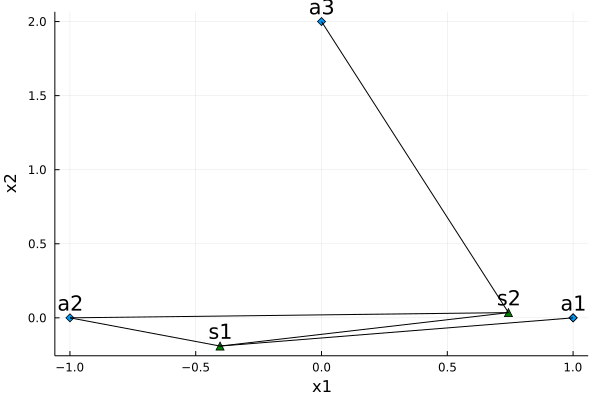

In [6]:
plt_loc9(A,X_true)

In [7]:
# SOCP relaxation
function socp_loc9(A,d)
    socp = Model(Mosek.Optimizer)
    set_silent(socp)
    @variable(socp, X[1:n,1:2])
    
    @constraint(socp, [d[1]; A[:,1] .- X[:,1]] in SecondOrderCone())
    @constraint(socp, [d[2]; A[:,2] .- X[:,1]] in SecondOrderCone())
    @constraint(socp, [d[3]; A[:,2] .- X[:,2]] in SecondOrderCone())
    @constraint(socp, [d[4]; A[:,3] .- X[:,2]] in SecondOrderCone())
    @constraint(socp, [d[5]; X[:,1] .- X[:,2]] in SecondOrderCone())

    optimize!(socp)

    #@show objective_value(socp)
    X_sol = value.(X)

    return X_sol
end

socp_loc9 (generic function with 1 method)

In [8]:
X_socp = socp_loc9(A,d)
println(LinearAlgebra.norm(X_true - X_socp))

1.275220744210182


In [9]:
# SDP relaxation 
function sdp_loc9(A,d)
    sdp = Model(Mosek.Optimizer)
    set_silent(sdp)
    @variable(sdp, X[1:n,1:2])
    @variable(sdp, Y[1:2,1:2])
    @variable(sdp, Z[1:n+2, 1:n+2], PSD)
    @constraint(sdp, Z .== [LinearAlgebra.I X; X' Y] )
    

    @constraint(sdp, sum(([A[:,1]; -1; 0]*[A[:,1]; -1; 0]').* Z) == d[1]^2 )
    @constraint(sdp, sum(([A[:,2]; -1; 0]*[A[:,2]; -1; 0]').* Z) == d[2]^2 )
    
    @constraint(sdp, sum(([A[:,2]; 0; -1]*[A[:,2]; 0; -1]').* Z) == d[3]^2 )
    @constraint(sdp, sum(([A[:,3]; 0; -1]*[A[:,3]; 0; -1]').* Z) == d[4]^2 )
    
    @constraint(sdp, sum(([0;0; 1; -1]*[0;0; 1; -1]').* Z) == d[5]^2 )
    
    optimize!(sdp)

    #@show objective_value(socp)
    X_sol = value.(X)

    return X_sol
end

sdp_loc9 (generic function with 1 method)

In [10]:
X_sdp = sdp_loc9(A,d)
println(LinearAlgebra.norm(X_true - X_sdp))

0.26170549738955917


In [11]:
function eval_f_snl(X,A,d) # nonlinear least squres objective
    X12 = X[:,1] - X[:,2]
    X1A1 = X[:,1] - A[:,1]
    X1A2 = X[:,1] - A[:,2]
    X2A2 = X[:,2] - A[:,2]
    X2A3 = X[:,2] - A[:,3]
    
    temp = (X12'*X12 - d[5]^2)^2 + (X1A1'*X1A1 - d[1]^2)^2 + (X1A2'*X1A2 - d[2]^2)^2 + (X2A2'*X2A2 - d[3]^2)^2 + (X2A3'*X2A3 - d[4]^2)^2
    return 0.25*temp

end
    
eval_f_snl(X_true,A,d)

6.162975822039155e-32

In [12]:


function sdm(A,d,X0) # steepest descent method
    
    X = X0
    maxiter = 10000
    stoptol = 1e-6
    stopflag = false
    for k in 1:maxiter
        
        # compute gradient 
        X12 = X[:,1] - X[:,2]
        X1A1 = X[:,1] - A[:,1]
        X1A2 = X[:,1] - A[:,2]
        X2A2 = X[:,2] - A[:,2]
        X2A3 = X[:,2] - A[:,3]
        
        g = (X12'*X12 - d[5]^2)*[X12 -X12] + (X1A1'*X1A1 - d[1]^2)*[X1A1 zeros(2,1)] + (X1A2'*X1A2 - d[2]^2)*[X1A2 zeros(2,1)] + (X2A2'*X2A2 - d[3]^2)*[zeros(2,1) X2A2] + (X2A3'*X2A3 - d[4]^2)*[zeros(2,1) X2A3] 
        
        
        gs = sum(g.*g) # gradient norm squre
        f = eval_f_snl(X, A, d)
        #println("obj is $f, grad norm is $(sqrt(gs))")
        if sqrt(gs) <= stoptol
            stopflag = true
    
            #println("stationary point found: stopped at norm(g) = $(sqrt(gs))")
            break
        end
        
        # determine stepsize using forward-backward tracking method
        stepsize = 1 
        flag = 0
        while eval_f_snl(X - stepsize * g, A, d) <= f - 0.5*stepsize*gs
            
            stepsize = stepsize * 2
            flag = 1
        end
        stepsize = 0.5*stepsize
        if flag==0
        
            while eval_f_snl(X - stepsize * g, A, d) > f - 0.5*stepsize*gs
                stepsize = stepsize * 0.5
            end
        end
        #println("stepsize is $stepsize")
        
        X = X - stepsize*g # udpate X by a steepest descent step
            
    end
    
    if stopflag == false
        println("stopped due to maximum iteration achieved")  
    end
    return X
end

sdm (generic function with 1 method)

initial nonlinear LS objective: 1.8932485703430544
initial solution error 0.8673410837891453
Final nonlinear LS objective after SDM: 8.75904145574141e-5
Final solution error after SDM: 0.3891397853260022


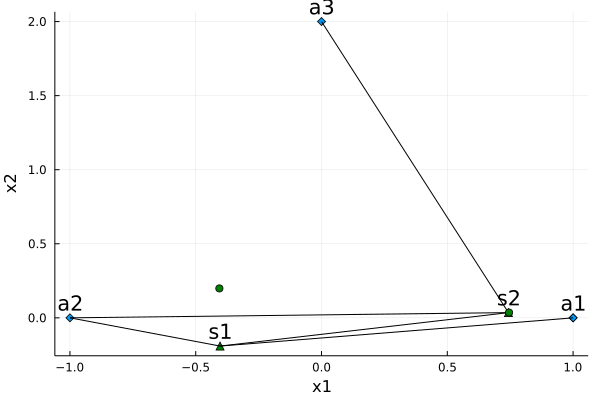

In [13]:
# run SDM starting from the origin
X0 = zeros(2,2)
println("initial nonlinear LS objective: $(eval_f_snl(X0, A, d))")
println("initial solution error $(LinearAlgebra.norm(X_true - X0))")
X_sdm = sdm(A,d,X0)
println("Final nonlinear LS objective after SDM: $(eval_f_snl(X_sdm, A, d))")
println("Final solution error after SDM: $(LinearAlgebra.norm(X_true - X_sdm))")

plot!(X_sdm[1,:], X_sdm[2,:], seriestype=:scatter, markershape = :circle,  markercolor=:green, legend = false)

In [14]:
# run SDM starting from a random point
Random.seed!(222)
error_tol = 1e-6 
run_num = 1000

count_rand = 0 # count the number of exact recovery, starting from a random point
for i in 1:run_num 
    
    X0 = (rand(n,2) .- 0.5).*3 # random initial point 
    X_sdm = sdm(A,d,X0)
    if LinearAlgebra.norm(X_true - X_sdm)/(1+LinearAlgebra.norm(X_true)) < error_tol
        count_rand += 1
        #println("initial error is $(LinearAlgebra.norm(X_true - X0)), error after SDM is $(LinearAlgebra.norm(X_true - X_sdm)) ")
    end
    
end
println("starting from a random point, the number of exact recovery (solution error $error_tol) is $count_rand out of $run_num ")   
# Some recovery is not accurate, change error tolerance to 1e-5 or 1e-4
# We can also set a smaller tolerance for SDM, e.g., set stoptol = 1e-8 to improve the solution accuracy

starting from a random point, the number of exact recovery (solution error 1.0e-6) is 1 out of 1000 


In [15]:
# run SDM starting from a random point
Random.seed!(222)
error_tol = 1e-4

count_rand = 0 # count the number of exact recovery, starting from a random point

for i in 1:run_num 
    
    X0 = (rand(n,2) .- 0.5).*3 # random initial point 
    X_sdm = sdm(A,d,X0)
    if LinearAlgebra.norm(X_true - X_sdm)/(1+LinearAlgebra.norm(X_true)) < error_tol
        count_rand += 1
        #println("initial error is $(LinearAlgebra.norm(X_true - X0)), error after SDM is $(LinearAlgebra.norm(X_true - X_sdm)) ")
    end
    
end
println("starting from a random point, the number of exact recovery (solution error $error_tol) is $count_rand out of $run_num ")   


starting from a random point, the number of exact recovery (solution error 0.0001) is 425 out of 1000 


## comparision of different methods

In [16]:
# see how sdm helps convex relaxation
count_sdp = 0
count_sdpsdm = 0
count_socp = 0
count_socpsdm = 0
count_sdm = 0

Random.seed!(222)
error_tol = 1e-6
run_num = 1000
for i in 1:run_num
    
    X_true = (rand(n,2) .- 0.5).*2

    d = get_d9(A,X_true)
    
    X_sdm = sdm(A,d,zeros(n,2))
    
    X_sdp = sdp_loc9(A,d)
    X_sdpsdm = sdm(A,d,X_sdp)
    
    X_socp = socp_loc9(A,d)
    X_socpsdm = sdm(A,d,X_socp)
    
    if LinearAlgebra.norm(X_true - X_sdp)/(1+LinearAlgebra.norm(X_true)) < error_tol
        
        count_sdp += 1
   
    end
    if LinearAlgebra.norm(X_true - X_sdpsdm)/(1+LinearAlgebra.norm(X_true)) < error_tol
        
        count_sdpsdm += 1
   
    end
    if LinearAlgebra.norm(X_true - X_socp)/(1+LinearAlgebra.norm(X_true)) < error_tol
        
        count_socp += 1
   
    end
    if LinearAlgebra.norm(X_true - X_socpsdm)/(1+LinearAlgebra.norm(X_true)) < error_tol
        
        count_socpsdm += 1
   
    end
    if LinearAlgebra.norm(X_true - X_sdm)/(1+LinearAlgebra.norm(X_true)) < error_tol
        
        count_sdm += 1
   
    end
end 

println("SDM (start from origin) recovers $(count_sdm/run_num)")
println("SDP recovers $(count_sdp/run_num); SDP+SDM recovers $(count_sdpsdm/run_num)")
println("SOCP recovers $(count_socp/run_num); SOCP+SDM recovers $(count_socpsdm/run_num)")

SDM (start from origin) recovers 0.603
SDP recovers 0.252; SDP+SDM recovers 0.776
SOCP recovers 0.015; SOCP+SDM recovers 0.562


## Problem 6

### Part I 

In [17]:
A = [1 1 1; 1 1 2; 1 2 2]
x0 = randn(3)
lambda0 = randn(3)
println(x0, lambda0)

[-0.7243136460199838, 1.06462542996306, -0.21316347877648972][1.4448987651160823, 0.7422934919644463, 0.23154682827229575]


### (a)

The objective function $$L(x;\lambda) = - \lambda^\top A x  + \frac{\beta}{2} \|A x \|_2^2 
=  - \sum_{i=1}^3 \lambda^\top A_i x_i + \frac{\beta}{2} \|\sum_{i=1}^3 A_i x_i \|_2^2  $$

In [18]:
# run ADMM
maxiter = 1000

beta_array = [0.1,1,10]

residual_array = ones((length(beta_array),maxiter))

for (beta_idx, beta) in enumerate(beta_array)
    
    x = copy(x0)
    lambda = copy(lambda0)
    for k in 1:maxiter

        x[1] =  (A[:,1]' * (lambda/beta - A[:,2:3]*x[2:3]) ) / (A[:,1]'*A[:,1])
        x[2] =  (A[:,2]' * (lambda/beta - A[:,[1,3]]*x[[1,3]]) ) / (A[:,2]'*A[:,2])
        x[3] =  (A[:,3]' * (lambda/beta - A[:,1:2]*x[1:2]) ) / (A[:,3]'*A[:,3])

        lambda = lambda - beta*A * x # when beta = 10, replace the dual step size beta by 0.1*beta works
        residual_array[beta_idx, k] = LinearAlgebra.norm(x)
    end
end

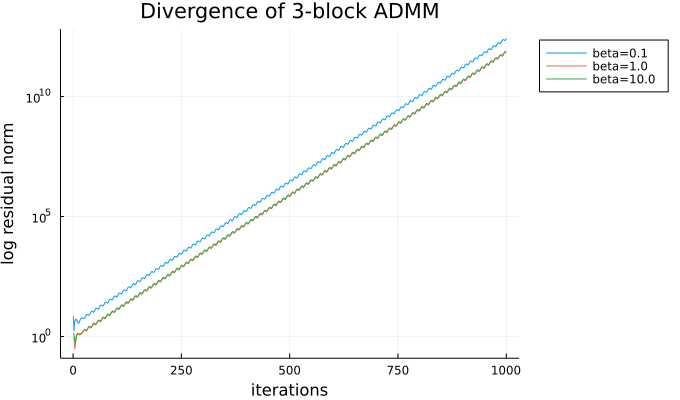

In [19]:

fig = plot()
for (beta_idx, beta) in enumerate(beta_array)
    if beta > 0
        plot!(1:maxiter, residual_array[beta_idx, :], yaxis=:log10, label="beta=$beta",legend = :outertopright)
    end 
end
xlabel!("iterations")
ylabel!("log residual norm")
title!("Divergence of 3-block ADMM")
plot!(size=(680,400))
display(fig)
#savefig("Parta-divergence.pdf")

### (b)

The objective function $$L(x;\lambda) = \frac{1}{2}\|x\|_2^2 - \lambda^\top A x  + \frac{\beta}{2} \|A x \|_2^2 
= 0.5(x_1^2+x_2^2+x_3^2) - \sum_{i=1}^3 \lambda^\top A_i x_i + \frac{\beta}{2} \|\sum_{i=1}^3 A_i x_i \|_2^2  $$


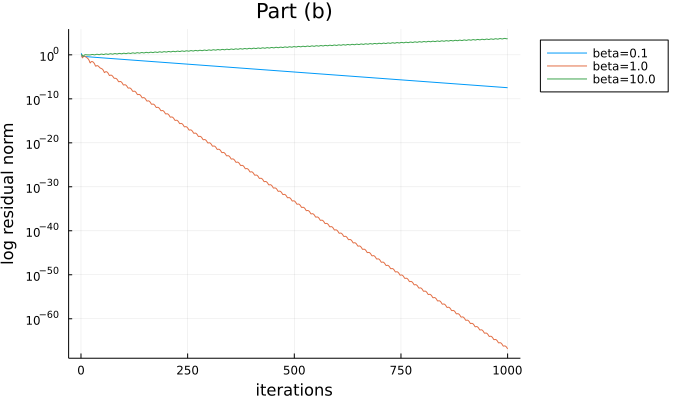

In [20]:


beta_array = [0.1,1,10]

residual_array = ones((length(beta_array),maxiter))

for (beta_idx, beta) in enumerate(beta_array)
    
    x = copy(x0)
    lambda = copy(lambda0)
    for k in 1:maxiter

        x[1] =  (A[:,1]' * (lambda/beta - A[:,2:3]*x[2:3]) ) / (1/beta+A[:,1]'*A[:,1])
        x[2] =  (A[:,2]' * (lambda/beta - A[:,[1,3]]*x[[1,3]]) ) / (1/beta+A[:,2]'*A[:,2])
        x[3] =  (A[:,3]' * (lambda/beta - A[:,1:2]*x[1:2]) ) / (1/beta+A[:,3]'*A[:,3])

        lambda = lambda - beta*A * x 
        residual_array[beta_idx, k] = LinearAlgebra.norm(x)
    end
end

fig = plot()
for (beta_idx, beta) in enumerate(beta_array)
    if beta > 0
        plot!(1:maxiter, residual_array[beta_idx, :], yaxis=:log10, label="beta=$beta", legend = :outertopright)
    end 
end
xlabel!("iterations")
ylabel!("log residual norm")
title!("Part (b)")
plot!(size=(680,400))
display(fig)

### Part (c)

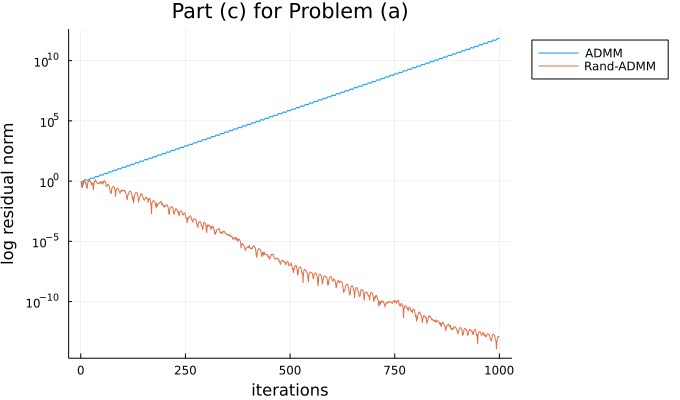

In [21]:


beta = 1

residual_array = ones((2,maxiter))
    
x = copy(x0)
lambda = copy(lambda0)
for k in 1:maxiter

    x[1] =  (A[:,1]' * (lambda/beta - A[:,2:3]*x[2:3]) ) / (A[:,1]'*A[:,1])
    x[2] =  (A[:,2]' * (lambda/beta - A[:,[1,3]]*x[[1,3]]) ) / (A[:,2]'*A[:,2])
    x[3] =  (A[:,3]' * (lambda/beta - A[:,1:2]*x[1:2]) ) / (A[:,3]'*A[:,3])

    lambda = lambda - beta*A * x 
    residual_array[1, k] = LinearAlgebra.norm(x)
end



x = copy(x0)
lambda = copy(lambda0)
for k in 1:maxiter
    perm = randperm(3)
    x[perm[1]] =  (A[:,perm[1]]' * (lambda/beta - A[:,perm[2:3]]*x[perm[2:3]]) ) / (A[:,perm[1]]'*A[:,perm[1]])
    x[perm[2]] =  (A[:,perm[2]]' * (lambda/beta - A[:,perm[[1,3]]]*x[perm[[1,3]]]) ) / (A[:,perm[2]]'*A[:,perm[2]])
    x[perm[3]] =  (A[:,perm[3]]' * (lambda/beta - A[:,perm[1:2]]*x[perm[1:2]]) ) / (A[:,perm[3]]'*A[:,perm[3]])

    lambda = lambda - beta*A * x 
    residual_array[2, k] = LinearAlgebra.norm(x)
end



fig = plot()

plot!(1:maxiter, residual_array[1, :], yaxis=:log10, label="ADMM", legend = :outertopright)
plot!(1:maxiter, residual_array[2, :], yaxis=:log10, label="Rand-ADMM", legend = :outertopright)

xlabel!("iterations")
ylabel!("log residual norm")
title!("Part (c) for Problem (a)")
plot!(size=(680,400))
display(fig)


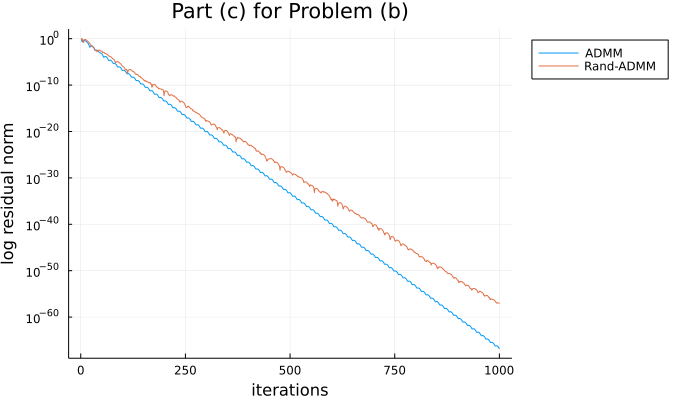

In [22]:


beta = 1

residual_array = ones((2,maxiter))
    
x = copy(x0)
lambda = copy(lambda0)
for k in 1:maxiter

    x[1] =  (A[:,1]' * (lambda/beta - A[:,2:3]*x[2:3]) ) / (1/beta+A[:,1]'*A[:,1])
    x[2] =  (A[:,2]' * (lambda/beta - A[:,[1,3]]*x[[1,3]]) ) / (1/beta+A[:,2]'*A[:,2])
    x[3] =  (A[:,3]' * (lambda/beta - A[:,1:2]*x[1:2]) ) / (1/beta+A[:,3]'*A[:,3])

    lambda = lambda - beta*A * x 
    residual_array[1, k] = LinearAlgebra.norm(x)
end



x = copy(x0)
lambda = copy(lambda0)
for k in 1:maxiter
    perm = randperm(3)
    x[perm[1]] =  (A[:,perm[1]]' * (lambda/beta - A[:,perm[2:3]]*x[perm[2:3]]) ) / (1/beta+A[:,perm[1]]'*A[:,perm[1]])
    x[perm[2]] =  (A[:,perm[2]]' * (lambda/beta - A[:,perm[[1,3]]]*x[perm[[1,3]]]) ) / (1/beta+A[:,perm[2]]'*A[:,perm[2]])
    x[perm[3]] =  (A[:,perm[3]]' * (lambda/beta - A[:,perm[1:2]]*x[perm[1:2]]) ) / (1/beta+A[:,perm[3]]'*A[:,perm[3]])

    lambda = lambda - beta*A * x 
    residual_array[2, k] = LinearAlgebra.norm(x)
end



fig = plot()

plot!(1:maxiter, residual_array[1, :], yaxis=:log10, label="ADMM", legend = :outertopright)
plot!(1:maxiter, residual_array[2, :], yaxis=:log10, label="Rand-ADMM", legend = :outertopright)

xlabel!("iterations")
ylabel!("log residual norm")
title!("Part (c) for Problem (b)")
plot!(size=(680,400))
display(fig)


### Part II

In [23]:
Random.seed!(222)

m = 10
n = 30


Q = rand(n, n)
Q = Q * Q' 
println("The smallest eigenvalue of Q is $(LinearAlgebra.eigmin(Q))")
#println("The condition number of Q is $(LinearAlgebra.cond(Q))")
A = randn(m, n)
println("The rank of A is $(LinearAlgebra.rank(A))")
#println("The condition number of AA' is $(LinearAlgebra.cond(A*A'))")
x_b = rand(n)
b = A*x_b

x0 = rand(n)
y0= rand(m)

Qeig = LinearAlgebra.eigen(Q)
Qs = Qeig.vectors * LinearAlgebra.Diagonal(sqrt.(max.(0,Qeig.values) )) * Qeig.vectors'
println(LinearAlgebra.norm( Q - Qs * Qs) )
# we can generate different Q for testing, the smallest eigenvalue will affect the convergence of ADMM significanly

The smallest eigenvalue of Q is 0.001849308912527514
The rank of A is 10
1.6788921646267807e-13


In [24]:
# we use Mosek to obtain a solution for plotting the residual
model = Model(Mosek.Optimizer)

set_silent(model)
@variable(model, x[1:n] ) # for simplicity we assume x is free
@variable(model, y[1:n] )

@constraint(model, A* x .== b)
@constraint(model, y .== Qs * x)

@objective(model, Min, 0.5*y'*y)
optimize!(model)
@show objective_value(model)

x_true = value.(x)
println(x_true)

objective_value(model) = 2.311964764977774
[-1.1242949430590956, -0.4197608121322708, -0.2533540419897805, -1.6258537004419802, 0.3849124514471672, 0.9317991634013746, 1.2779490467629981, 1.3594927158279622, 1.065799868107321, 1.5798659717473116, 0.9535545535102912, 1.2571636522573282, 0.3234450511276453, -0.8995408429879451, 0.7208614048337311, 1.4184114469975728, 0.5563901463374064, -0.3112196237630663, -1.4821797967180472, -1.9635429556894246, -1.4526121903982245, -0.9626862089123852, -0.013068642621448499, -0.649431689605275, -1.7484369942027387, 0.5018330143381778, -0.5925714205607925, -0.09695709050694216, 0.9675187801576106, 0.012986120222568268]


In [25]:
maxiter = 10000
beta = 1
x_error = zeros((3,maxiter))


3×10000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [26]:
# naive 5-block ADMM
x = copy(x0)
y = copy(y0)

for k in 1:maxiter
    x_error[1,k] = LinearAlgebra.norm(x - x_true)
    for i in 1:5
        blk = 6*(i-1)+1: 6*i
        blkc = setdiff(1:30, blk)
        
        prob = LinearSolve.LinearProblem(beta*(A[:,blk]'*A[:,blk]) + Q[blk,blk], 
            A[:,blk]'*y + beta.*A[:,blk]'*(b - A[:,blkc]*x[blkc]) - Q[blk, blkc]*x[blkc] )
        sol = LinearSolve.solve(prob)

        x[blk] = sol.u
    end
    
    y = y + beta.*(b - A*x)
    
end

In [27]:
# random 5-block ADMM
x = copy(x0)
y = copy(y0)
x_error_r = zeros(maxiter)
for k in 1:maxiter
    x_error[2,k] = LinearAlgebra.norm(x - x_true)
    perm = randperm(5)
    for i in perm
        blk = 6*(i-1)+1: 6*i
        blkc = setdiff(1:30, blk)
        
        prob = LinearSolve.LinearProblem(beta*(A[:,blk]'*A[:,blk]) + Q[blk,blk], 
            A[:,blk]'*y + beta.*A[:,blk]'*(b - A[:,blkc]*x[blkc]) - Q[blk, blkc]*x[blkc] )
        sol = LinearSolve.solve(prob)

        x[blk] = sol.u
    end
    
    y = y + beta.*(b - A*x)
    
end

In [28]:
# fully random ADMM
x = copy(x0)
y = copy(y0)
x_error_r = zeros(maxiter)
for k in 1:maxiter
    x_error[3,k] = LinearAlgebra.norm(x - x_true)
    perm = randperm(n)
    for i in 1:5
        blk = perm[6*(i-1)+1: 6*i]
        blkc = setdiff(1:30, blk)
        
        prob = LinearSolve.LinearProblem(beta*(A[:,blk]'*A[:,blk]) + Q[blk,blk], 
            A[:,blk]'*y + beta.*A[:,blk]'*(b - A[:,blkc]*x[blkc]) - Q[blk, blkc]*x[blkc] )
        sol = LinearSolve.solve(prob)

        x[blk] = sol.u
    end
    
    y = y + beta.*(b - A*x)
    
end

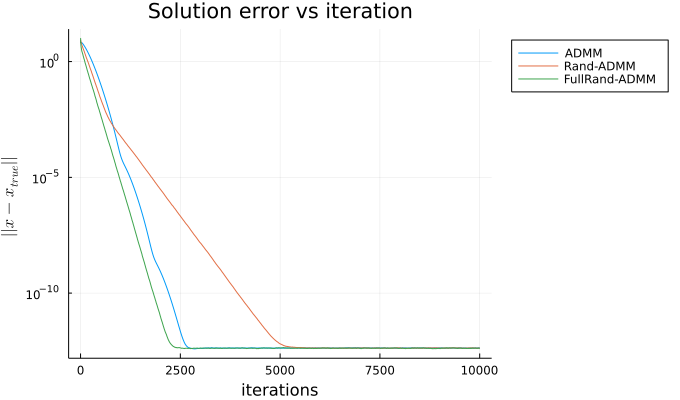

In [29]:
fig = plot()

plot!(1:maxiter, (x_error[1,:]), yaxis=:log10, label="ADMM", legend = :outertopright)
plot!(1:maxiter, (x_error[2,:]), yaxis=:log10, label="Rand-ADMM", legend = :outertopright)
plot!(1:maxiter, (x_error[3,:]), yaxis=:log10, label="FullRand-ADMM", legend = :outertopright)
xlabel!("iterations")
ylabel!(L"\||x-x_{true}\||")
title!("Solution error vs iteration")
plot!(size=(680,400))
display(fig)